In [1]:
from keras.datasets import mnist
import numpy as np

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
img_rows, img_cols, channels = 28, 28, 1
x_train = x_train.reshape(-1, img_rows, img_cols, channels)
x_test  = x_test.reshape(-1, img_rows, img_cols, channels)

In [ ]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

In [4]:
x_train = x_train.astype(np.float32)
x_test  = x_test.astype(np.float32)

x_train /= 255
x_test  /= 255

In [5]:
from keras.models import Input, Model
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop

In [6]:
g_dropout = 0.4
g_dim = 7
g_depth = 64 * 4
##g_depth = 8 * 4

g_input = Input(shape=(100,))
x = Dense(g_dim * g_dim * g_depth)(g_input)
x = BatchNormalization(momentum=0.9)(x)
x = Activation('relu')(x)
x = Reshape((g_dim, g_dim, g_depth))(x)
x = Dropout(g_dropout)(x)

x = UpSampling2D()(x)
##x = Conv2D(int(g_depth / 2), 5, padding='same')(x)
x = Conv2DTranspose(int(g_depth / 2), 5, padding='same')(x)
x = BatchNormalization(momentum=0.9)(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
##x = Conv2D(int(g_depth / 4), 5, padding='same')(x)
x = Conv2DTranspose(int(g_depth / 4), 5, padding='same')(x)
x = BatchNormalization(momentum=0.9)(x)
x = Activation('relu')(x)

##x = Conv2D(int(g_depth / 8), 5, padding='same')(x)
x = Conv2DTranspose(int(g_depth / 8), 5, padding='same')(x)
x = BatchNormalization(momentum=0.9)(x)
x = Activation('relu')(x)

##x = Conv2D(1, 5, padding='same')(x)
x = Conv2DTranspose(1, 5, padding='same')(x)
g_output = Activation('sigmoid')(x)


generator = Model(g_input, g_output)
#g_opt = Adam(lr=1e-3)
g_opt = RMSprop(lr=0.0001, decay=3e-8)
generator.compile(loss='binary_crossentropy', optimizer=g_opt)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_1 (Batch (None, 12544)             50176     
_________________________________________________________________
activation_1 (Activation)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 256)       0         
__________

In [7]:
d_dropout = 0.4
d_depth = 64
##d_depth = 4

d_input = Input(shape=(img_rows, img_cols, channels))
x = Conv2D(d_depth * 1, 5, strides=2, padding='same')(d_input)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(d_dropout)(x)

x = Conv2D(d_depth * 2, 5, strides=2, padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(d_dropout)(x)

x = Conv2D(d_depth * 4, 5, strides=2, padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(d_dropout)(x)

x = Conv2D(d_depth * 8, 5, strides=1, padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(d_dropout)(x)

x = Flatten()(x)
x = Dense(1)(x)
d_output = Activation('sigmoid')(x)

discriminator = Model(d_input, d_output)
#d_opt = Adam(lr=1e-4)
d_opt = RMSprop(lr=0.0002, decay=6e-8)
discriminator.compile(loss='binary_crossentropy', optimizer=d_opt)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)         0         
__________

In [8]:
# Freeze weights in the discriminator for stacked training
def make_trainable(net, boolean):
    net.trainable = boolean
    for l in net.layers:
        l.trainable = boolean

In [9]:
make_trainable(discriminator, False)
# Build stacked GAN model
g_stack_input  = Input(shape=(100,))
g_stack_output = generator(g_stack_input)
d_stack_output = discriminator(g_stack_output)

gan = Model(g_stack_input, d_stack_output)
gan.compile(loss='binary_crossentropy', optimizer=d_opt, metrics=['accuracy'])
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_1 (Model)              (None, 28, 28, 1)         2394241   
_________________________________________________________________
model_2 (Model)              (None, 1)                 4311553   
Total params: 6,705,794
Trainable params: 2,368,705
Non-trainable params: 4,337,089
_________________________________________________________________


In [10]:
ntrain = 10000
trainidx = np.random.choice(x_train.shape[0], size=ntrain)
x_tt = x_train[trainidx,:,:,:]
print(x_tt.shape)

(10000, 28, 28, 1)


In [ ]:
noise_gen = np.random.uniform(-1.0, 1.0, size=(x_tt.shape[0], 100))
generated_images = generator.predict(noise_gen)
xx = np.concatenate((x_tt, generated_images))
yy = np.concatenate((np.ones((x_tt.shape[0], 1)), np.zeros((x_tt.shape[0], 1))))

make_trainable(discriminator, True)
discriminator.fit(xx, yy, epochs=1, batch_size=32)

In [11]:
losses = {'d' : [], 'g' : []}

In [13]:
from tqdm import tqdm

def train_for_n(epochs = 5000, batch_size = 32):
    for e in tqdm(range(epochs)):
        image_batch = x_train[np.random.choice(x_train.shape[0], size=batch_size),:,:,:]
        noise_gen = np.random.uniform(-1.0, 1.0, size=(batch_size, 100))
        generated_images = generator.predict(noise_gen)
        
        xx = np.concatenate((image_batch, generated_images))
        yy = np.concatenate((np.ones((batch_size, 1)), np.zeros((batch_size, 1))))
        
        make_trainable(discriminator, True)
        d_loss = discriminator.train_on_batch(xx, yy)
        losses['d'].append(d_loss)
        
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(-1.0, 1.0, size=(batch_size, 100))
        yyy = np.ones((batch_size, 1))
        make_trainable(discriminator, False)
        g_loss = gan.train_on_batch(noise_tr, yyy)
        losses["g"].append(g_loss)

In [ ]:
train_for_n(epochs=2000, batch_size=128)

 94%|█████████▎| 1870/2000 [49:27<03:24,  1.58s/it]

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
def plot_loss(losses):
    plt.figure(figsize=(10,8))
    plt.plot(losses['d'], label='discriminitive loss')
    plt.plot(losses['g'], label='generative loss')
    plt.legend()

In [17]:
def plot_gen(n_ex=16,dim=(4,4), figsize=(10,10) ):
    noise = np.random.uniform(-1.0,1.0,size=[n_ex,100])
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,:,:,0]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()

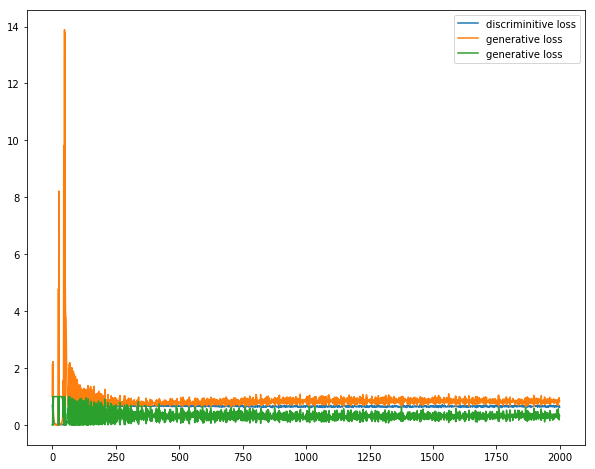

In [18]:
plot_loss(losses=losses)

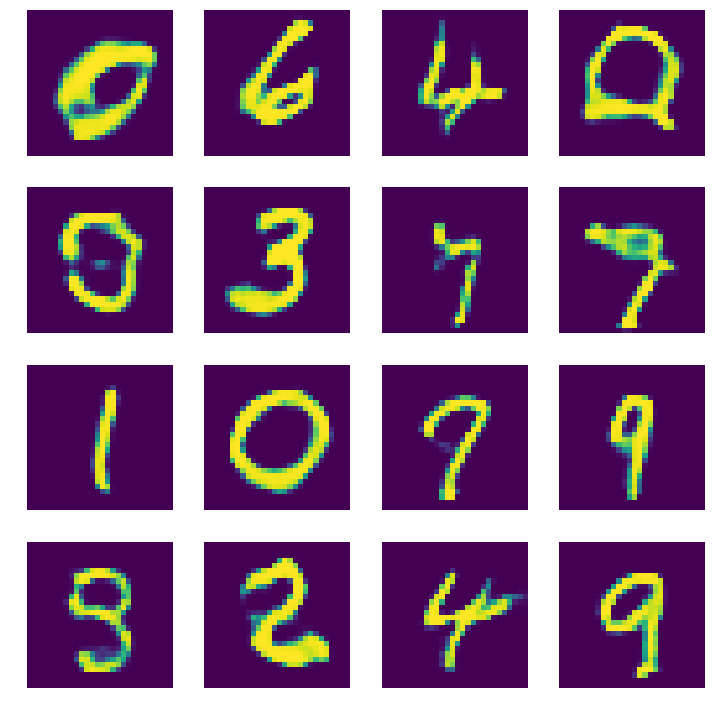

In [19]:
plot_gen()